In [3]:
import pandas as pd

Считаем данные по транзакциям и правильные метки возрастных категорий.

In [4]:
transactions_train = pd.read_csv('../data_in/transactions_train.csv')
train_target = pd.read_csv('../data_in/train_target.csv')

In [5]:
small_group = pd.read_csv('../data_in/small_group_description.csv')

In [6]:
transactions_test = pd.read_csv('../data_in/transactions_test.csv')
test_id = pd.read_csv('../data_in/test.csv')

* client_id - уникальный идентификатор клиента
* trans_date - дата совершения транзакции
* small_group - категория покупки
* amount_rur - сумма транзакции

In [7]:
transactions_train.head()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341


In [8]:
train_target.head()

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


In [9]:
small_group.head()

,small_group,small_group_code
0,Зоотовары,0
1,Сетевые супермаркеты и продуктовые магазины,1
2,Обслуживание существующего автомобиля (АЗС),2
3,Оплата телефона и связи,3
4,Аптеки,4


тестовый данные

In [67]:
train_i = list(set(train_target['client_id']))
len(train_i)

30000

In [68]:
test_i = list(set(test_id['client_id']))
len(test_i)

20000

In [12]:

def f_get_clients(df_transactions):
    """список клиентов"""
    
    # список клиентов
    test_i = list(set(df_transactions['client_id']))
    #df по клиентам
    test_f = pd.DataFrame(test_i, columns=['client_id'])
    return test_f

In [13]:
def f_agg_unique(df, list_clients):
    """"""
    df_unique = df.groupby('client_id').nunique()
    df_unique['client_id'] = list_clients
    df_sum = df.groupby('client_id').sum()
    df_sum['client_id'] = list_clients
    df_count = df.groupby('client_id').count()
    df_count['client_id'] = list_clients
    
    # сумма потраченая за все время
    df_unique['df_sum_amo'] = df_sum['amount_rur']
    # количество всех платежей
    df_unique['df_count_date'] = df_count['trans_date']
    
    #df_unique = df_unique.reset_index(drop=True)

    return df_unique

In [14]:
def f_agg_unique_inday(df):
    """"""
    #(сколько трат на одну услугу)
    df['sum_d_small'] = df['df_sum_amo'] / df['small_group']
    #(траты в день)
    df['sum_d_date'] = df['df_sum_amo'] / df['trans_date']
    #(сколько раз в день оплачивал)
    df['amount_d_trans'] = df['df_count_date'] / df['trans_date']
    #(сколько услуг в день)
    df['amount_d_small'] = df['df_count_date'] / df['small_group']
    
    return df

In [15]:
def f_agg_features(df_transactions):
    """Посчитаем по каждому клиенту самые простые аггрегационные признаки."""
    
    agg_features = df_transactions.groupby('client_id')['amount_rur'].agg(['sum','mean','std','min','max']).reset_index()
    
    return agg_features

In [16]:
def f_cat_counts_train(df_transactions):
    """Посчитаем для каждого клиента количество транзакций по каждой категории."""
    counter_df_train=df_transactions.groupby(['client_id','small_group'])['amount_rur'].count()
    cat_counts_train=counter_df_train.reset_index().pivot(index='client_id',
                                                          columns='small_group',
                                                          values='amount_rur')
    cat_counts_train=cat_counts_train.fillna(0)
    cat_counts_train.columns=['small_group_'+str(i) for i in cat_counts_train.columns]
    
    return cat_counts_train

In [17]:
def f_normalize(df, list_columns):
    """#Нормализация количественных признаков"""
    #df = df[list_columns]
    df[list_columns] = (df[list_columns] - df[list_columns].mean()) / df[list_columns].std()
    return df

In [18]:
def f_smallcat_TF(df_in):
    """small cat to True False"""
    df = df_in.copy()
    columns = df.columns
    for col in columns:
        df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)
        
    df = df.astype('uint8')
    return df

In [19]:
# функция находит пустые сроки и столбцы и выводит их
def f_data_is_npnan_colrow(datafile = 'df'):
    # функция находит пустые сроки и столбцы и выводит их
    col_mask = datafile.isnull().any(axis=0) 
    row_mask = datafile.isnull().any(axis=1)
    print(datafile.loc[row_mask,col_mask])

In [20]:
# объединение тестовых и тренироваочных фреймов
df_full = pd.concat([transactions_train, transactions_test], ignore_index=True)

In [69]:
clients_list = list(set(df_full['client_id']))
df_agg_unique = f_agg_unique(df_full, clients_list)
df_agg_unique = df_agg_unique.reset_index(drop=True)

In [70]:
agg_unique = df_agg_unique.copy()
agg_unique = f_agg_unique_inday(agg_unique)

In [71]:
agg_features = f_agg_features(df_full)

In [72]:
cat_counts_train = f_cat_counts_train(df_full)

In [73]:
cat_counts_train2 = f_smallcat_TF(cat_counts_train)
cat_counts_train2['client_id'] = clients_list
cat_counts_train2 = cat_counts_train2.reset_index(drop=True)

Далее соединим все файлы в один датафрейм с таргетом.

In [74]:
train = pd.merge(train_target, agg_features, on='client_id')

In [76]:
train = pd.merge(train, cat_counts_train.reset_index(), on='client_id')

In [162]:
train = pd.merge(train, agg_unique, on='client_id')

In [52]:
train = f_normalize(train, train.columns[2:])

In [163]:
train

,client_id,bins,sum,mean,std,min,max,small_group_0,small_group_1,small_group_2,...,small_group_203,trans_date,small_group,amount_rur,df_sum_amo,df_count_date,sum_d_small,sum_d_date,amount_d_trans,amount_d_small
0,24662,2,30254.011,34.774725,72.037354,0.074,1227.314,0.0,174.0,2.0,...,0.0,491,33,740,30254.011,870,916.788212,61.617130,1.771894,26.363636
1,1046,0,42548.570,52.015367,106.540962,0.550,1210.506,1.0,187.0,61.0,...,0.0,469,42,636,42548.570,818,1013.061190,90.721898,1.744136,19.476190
2,34089,2,26842.816,34.325852,59.927450,0.043,782.641,0.0,372.0,0.0,...,0.0,501,35,649,26842.816,782,766.937600,53.578475,1.560878,22.342857
3,34848,1,15773.126,16.160990,14.224936,0.043,109.590,0.0,359.0,1.0,...,0.0,433,17,732,15773.126,976,927.830941,36.427543,2.254042,57.411765
4,47076,3,12488.375,15.929050,35.473591,0.432,541.165,0.0,378.0,0.0,...,0.0,480,17,585,12488.375,784,734.610294,26.017448,1.633333,46.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,14303,1,285001.426,345.456274,1009.576868,1.786,9919.347,0.0,284.0,26.0,...,0.0,465,54,743,285001.426,825,5277.804185,612.906292,1.774194,15.277778
29996,22301,2,34950.321,49.715962,116.602464,0.043,2136.877,2.0,168.0,9.0,...,0.0,412,49,519,34950.321,703,713.271857,84.830876,1.706311,14.346939
29997,25731,0,54074.454,49.338005,80.490725,0.181,884.970,0.0,266.0,8.0,...,0.0,537,43,834,54074.454,1096,1257.545442,100.697307,2.040968,25.488372
29998,16820,3,32494.435,42.643615,136.489534,0.388,2959.186,2.0,340.0,3.0,...,0.0,488,41,608,32494.435,762,792.547195,66.586957,1.561475,18.585366


In [78]:
f_data_is_npnan_colrow(train)

Empty DataFrame
Columns: []
Index: []


In [55]:
# удаление пустых столбцов
# train.drop(['small_group_194', 'small_group_201'], axis=1, inplace=True)

In [79]:

import numpy as np


# импорт моделей
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_squared_error, confusion_matrix


In [164]:
itog_val = {}
k_fold = 3
random_state = 777

In [165]:
X = train.drop('bins', axis=1)
y = train['bins']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
print(X_train.shape, y_train.shape)

(20100, 219) (20100,)


In [83]:


def f_rmse_score(model, X_train, X_test, y_train, y_test):
    #среднеквадратичная ошибка или среднеквадратичное отклонение оценщика измеряет среднее значение квадратов ошибок, 
    #то есть среднеквадратическую разницу между оценочными значениями и фактическим значением. 
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5
    
    print("The training RMSE for " + str(model) + " is: " + str(rmse_train))
    print("The testing RMSE for " + str(model) + " is: " + str(rmse_test))
    return (rmse_train, rmse_test)



def f_err_predict_test_train(model, X_train, X_test, y_train, y_test):
    # ошибки на предсказания меток моделью
    
    err_train = np.mean(y_train != model.predict(X_train))
    err_test  = np.mean(y_test  != model.predict(X_test))
    
    print("ошибки на обучающей: {0:.2f}%".format(err_train*100))
    print("ошибки на тестовой: {0:.2f}%".format(err_test*100))
    
    
      
def f_cross_val_scores(model, X, y, k_fold=3):
    #
    scoring = 'accuracy'
    rslt = cross_val_score(model, X, y, cv=k_fold, n_jobs=-1, scoring=scoring)
    print(f'Результат кроссвалидации = {rslt}')
    #print(f'Среднее значение кроссвализации {rslt.mean()}')
    
    return rslt.mean()
     
    

In [84]:
#model RandomForestClassifier
model_rfc = RandomForestClassifier(max_depth = 33, 
                                   min_samples_leaf = 8,
                                   min_samples_split = 2,
                                   n_estimators = 600,
                                   random_state=random_state)
predict = model_rfc.fit(X_train, y_train).predict(X_test)

#f_rmse_score(model_rfc, X_train, X_test, y_train, y_test)

f_err_predict_test_train(model_rfc, X_train, X_test, y_train, y_test)
itog_val['RandomForestClassifier'] = f_cross_val_scores(model_rfc, X, y, k_fold)

print(accuracy_score(y_test, predict))   #0.5924

ошибки на обучающей: 12.21%
ошибки на тестовой: 40.58%
Результат кроссвалидации = [0.5893 0.5945 0.5945]
0.5942424242424242


In [161]:
# модель GradientBoostingClassifier
model_gbc = GradientBoostingClassifier(learning_rate=0.1, 
                                       min_samples_leaf=2, 
                                       min_samples_split=10,
                                       n_estimators=220, 
                                       random_state=random_state)
predict = model_gbc.fit(X_train, y_train).predict(X_test)

#f_rmse_score(model_gbc, X_train, X_test, y_train, y_test)

f_err_predict_test_train(model_gbc, X_train, X_test, y_train, y_test)
itog_val['GradientBoostingClassifier'] = f_cross_val_scores(model_gbc, X, y, k_fold)

print(accuracy_score(y_test, predict)) # 0.6115

KeyboardInterrupt: 

In [188]:
# модель lightgbm
model_lgb = lgb.LGBMClassifier(num_leaves=31,
                               max_depth=-1,
                               learning_rate=0.1,
                               n_estimators=600,
                               min_child_samples=19,
                               random_state = random_state)
predict = model_lgb.fit(X_train, y_train).predict(X_test)

#f_rmse_score(model_lgb, X_train, X_test, y_train, y_test)

f_err_predict_test_train(model_lgb, X_train, X_test, y_train, y_test)
#itog_val['LGBMClassifier'] = f_cross_val_scores(model_lgb, X, y, k_fold)

print(accuracy_score(y_test, predict))  #0.6094949494949495 61535 613

ошибки на обучающей: 0.24%
ошибки на тестовой: 38.69%
0.6131313131313131


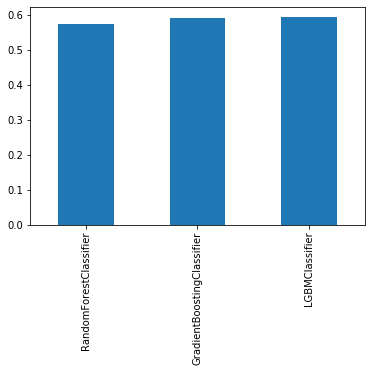

In [66]:
# Перекресная кросвалидация моделей
X.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [93]:
test = pd.merge(test_id, cat_counts_train.reset_index(), on='client_id')

test = pd.merge(test, agg_unique, on='client_id')

test = pd.merge(test, agg_features, on='client_id')

In [ ]:
test = f_normalize(test, test.columns[2:])

In [94]:
test.head()

,client_id,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,...,df_count_date,sum_d_small,sum_d_date,amount_d_trans,amount_d_small,sum,mean,std,min,max
0,28571,0.0,278.0,13.0,35.0,35.0,0.0,0.0,0.0,1.0,...,718,802.817974,66.755105,1.571116,18.894737,30507.083,42.488974,43.659666,0.078,306.882
1,27046,9.0,193.0,68.0,34.0,51.0,0.0,2.0,0.0,1.0,...,1010,678.931310,89.090534,2.285068,17.413793,39378.016,38.988135,93.600961,0.043,1469.007
2,13240,0.0,227.0,3.0,165.0,41.0,0.0,0.0,1.0,2.0,...,942,1167.700628,106.379506,1.995763,21.906977,50211.127,53.302683,198.583630,1.078,3902.918
3,19974,42.0,305.0,12.0,70.0,49.0,0.0,0.0,0.0,4.0,...,852,1031.170250,89.313959,1.677165,19.363636,45371.491,53.252924,273.597147,0.432,5865.551
4,10505,0.0,516.0,56.0,162.0,47.0,1.0,0.0,1.0,4.0,...,1109,1893.408917,157.238111,1.918685,23.104167,90883.628,81.950972,119.408720,0.043,1921.341


In [193]:
# список общих признаков
common_features = list(set(train.columns).intersection(set(test.columns)))

In [194]:
y_train=train['bins']
X_train=train[common_features]
X_test=test[common_features]

### Предсказание 

In [97]:
%%time
predict = model_gbc.fit(X_train, y_train).predict(X_test)

CPU times: user 6min 54s, sys: 4.17 s, total: 6min 58s
Wall time: 7min 37s


In [195]:
%%time
predict = model_lgb.fit(X_train, y_train).predict(X_test)

CPU times: user 1min 56s, sys: 1.98 s, total: 1min 58s
Wall time: 44.5 s


### Подготовим файл для отправки в систему

In [196]:
result = pd.DataFrame({'bins': predict}, index=test.client_id)
result.head()

,bins
client_id,
28571,0
27046,2
13240,3
19974,0
10505,1


In [197]:
from datetime import datetime
import os


date_current = datetime.today().strftime('%d%H%M')
file_name = f'../data_out/submission_{date_current}.csv'

if not os.path.exists('../data_out'):
    os.makedirs('../data_out')

print('file saved!', file_name)
result.to_csv(file_name, index=True)

file saved! ../data_out/submission_160107.csv
